In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

In [2]:
sns.set_theme(
  context="paper",
  style="whitegrid",
  palette="colorblind",
  font="Source Sans Pro",
)

In [3]:
%config InlineBackend.figure_format = "retina"

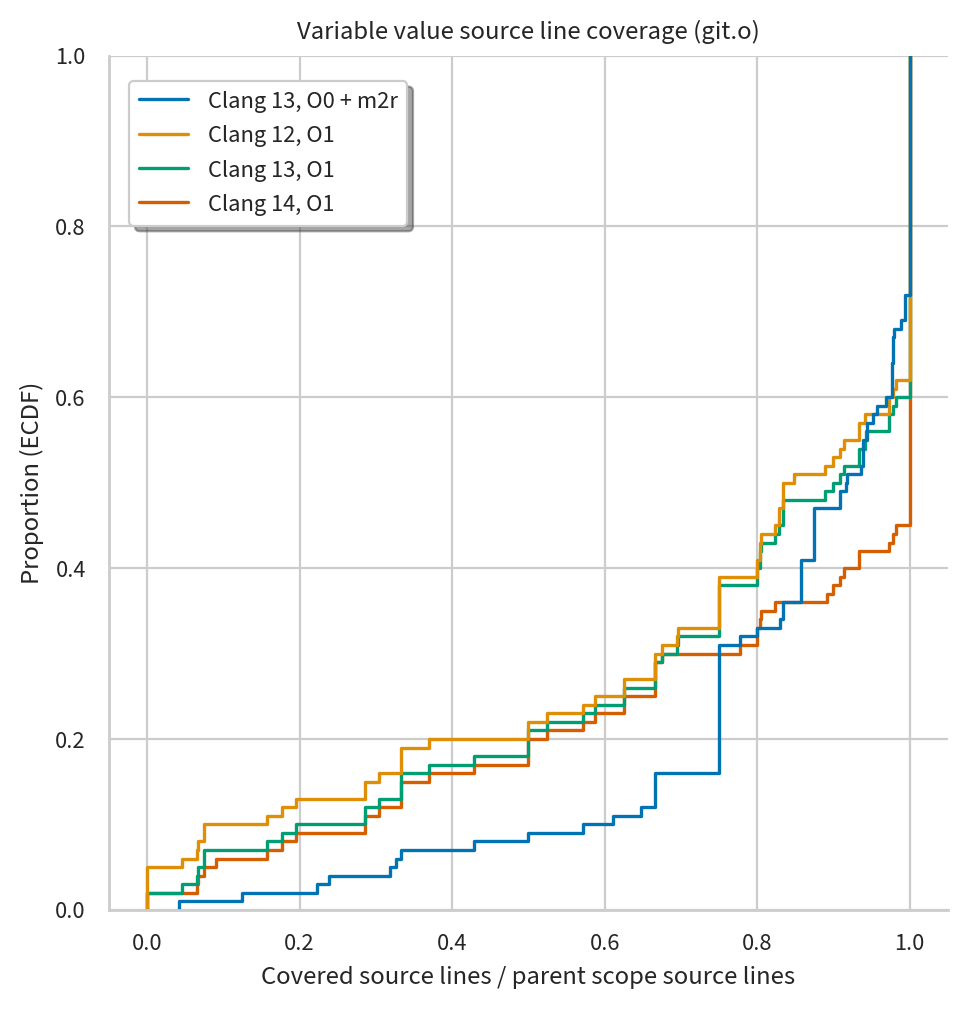

In [4]:
g = sns.displot(
  pd.read_csv("git.o-distribution.csv"),
  x="CL / SL",
  hue="Variant",
  kind="ecdf",
)
sns.move_legend(
  g,
  "upper left",
  bbox_to_anchor=(0.1, 0.95),
  frameon=True,
  shadow=True,
  title=None,
)
g.set(
  title="Variable value source line coverage (git.o)",
  xlabel="Covered source lines / parent scope source lines",
  ylabel="Proportion (ECDF)",
)

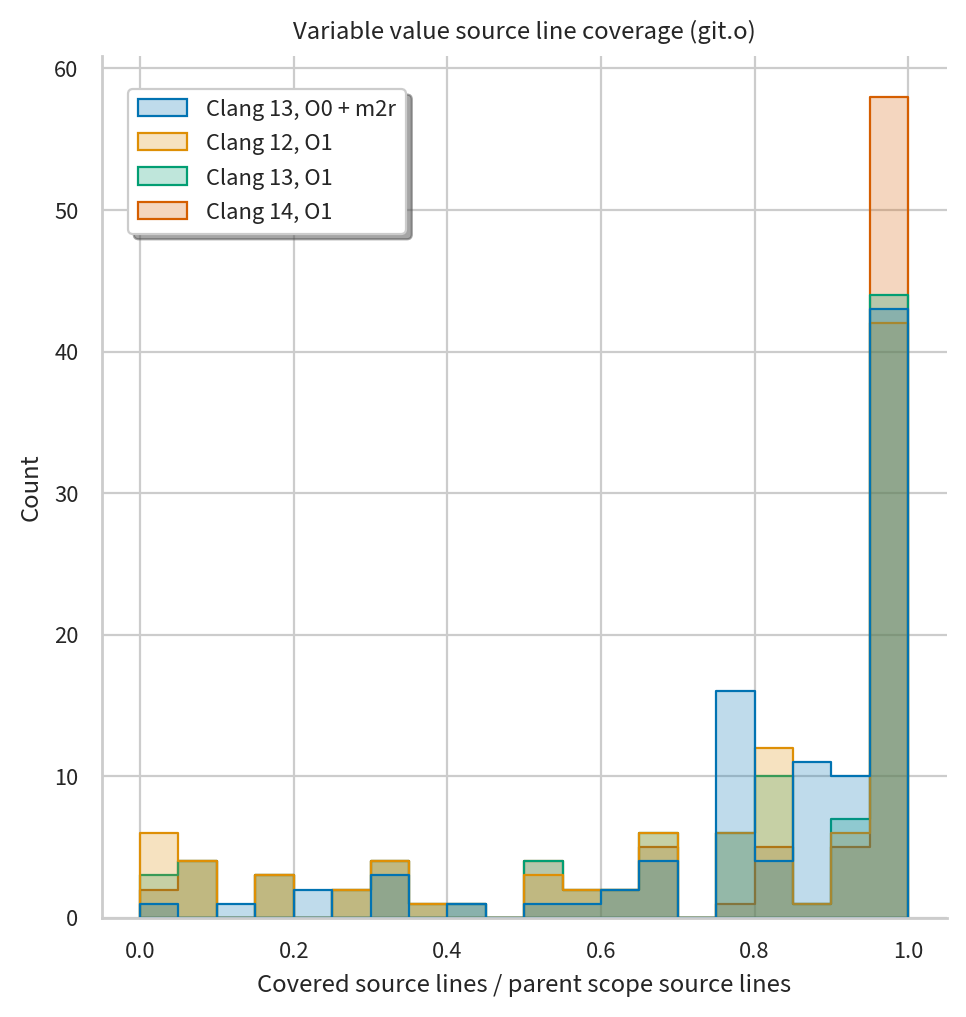

In [5]:
g = sns.displot(
  pd.read_csv("git.o-distribution.csv"),
  x="CL / SL",
  hue="Variant",
  element="step",
  bins=20,
)
sns.move_legend(
  g,
  "upper left",
  bbox_to_anchor=(0.1, 0.95),
  frameon=True,
  shadow=True,
  title=None,
)
g.set(
  title="Variable value source line coverage (git.o)",
  xlabel="Covered source lines / parent scope source lines",
)

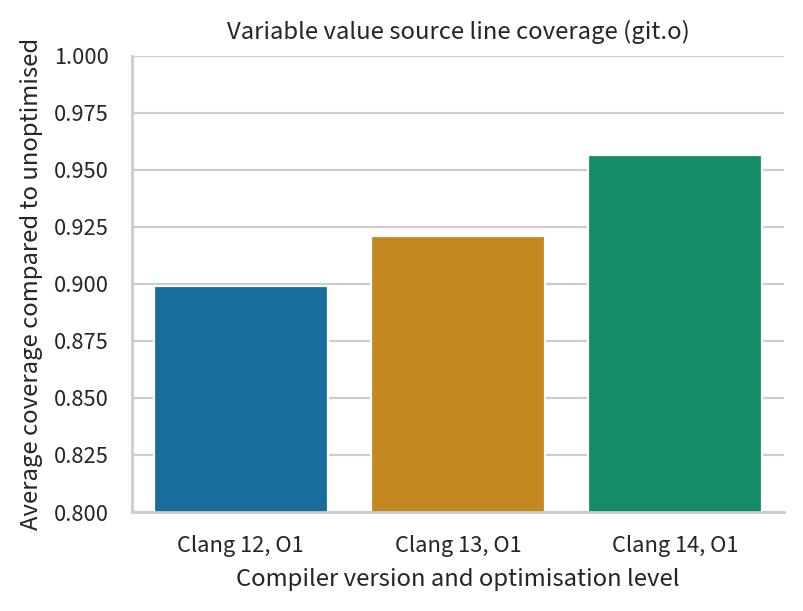

In [6]:
g = sns.catplot(
  pd.read_csv("git.o-average.csv"),
  x="Variant",
  y="Average Coverage",
  kind="bar",
  height=3.0,
  aspect=4 / 3,
)
g.set(
  title="Variable value source line coverage (git.o)",
  xlabel="Compiler version and optimisation level",
  ylabel="Average coverage compared to unoptimised",
  ybound=(0.8, 1.0),
)